In [1]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
import webbrowser
# import osmnx
# import geopandas as gp
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext line_profiler

In [325]:
sp_data = pd.read_csv('singapore_listings.csv')
print(sp_data.shape)
sp_data.head()

(7907, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


mean of price: 169.33299607942328
over average price percentage: 30.9%
lower average price percentage: 69.1%


(0, 1000)

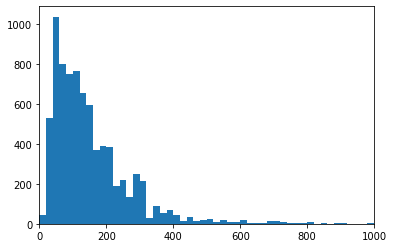

In [197]:
price = sp_data['price'].values
mean_price = np.mean(price)
print(f'mean of price: {mean_price}')
over_price = sum(sp_data['price'].values>mean_price)/len(price)
lower_price = sum(sp_data['price'].values<=mean_price)/len(price)
print(f'over average price percentage: {round(over_price*100,2)}%')
print(f'lower average price percentage: {round(lower_price*100,2)}%')
a,b,c = plt.hist(price,bins=500)
plt.xlim(0,1000)

## Feature Analysis

In [326]:
lat = sp_data['latitude'].values
lon = sp_data['longitude'].values

total number of latitude: 7907, average latitude: 1.3141924649045151


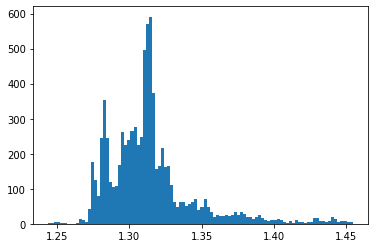

In [101]:
print(f'total number of latitude: {len(lat)}, average latitude: {np.mean(lat)}')
_,_,_ = plt.hist(lat, bins= 100)

total number of longitude: 7907, average longitude: 103.84878745794865


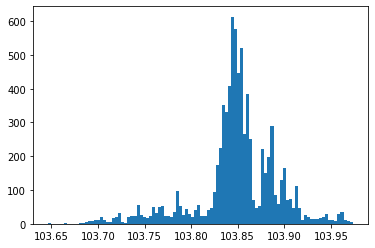

In [102]:
print(f'total number of longitude: {len(lon)}, average longitude: {np.mean(lon)}')
_,_,_ = plt.hist(lon, bins= 100)

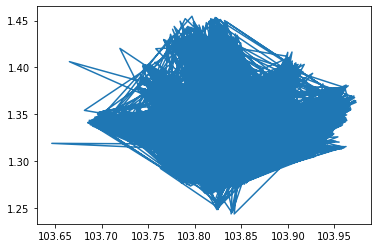

In [104]:
plt.plot(lon, lat)

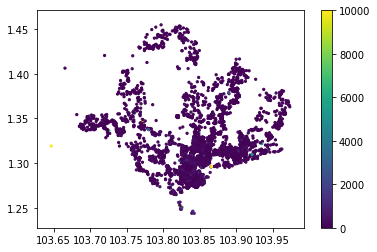

In [264]:
plt.scatter(lon, lat, c=price,s=5)
plt.colorbar()

## Pretrain and evaulate the model

In [329]:
def segment_position(pos_min_nights, pos_host_own, pos_avail, pos_price, lat_bins, lon_bins):
    keys, gmn, gho, ga, values = [], [], [], [], []
    lat, lon = sorted([x[0] for x in pos_price.keys()]), sorted([x[1] for x in pos_price.keys()])
    batch_lat, batch_lon = len(pos_price)//lat_bins, len(pos_price)//lon_bins
    for i in tqdm_notebook(range(lat_bins)):
        lat_gap = lat[i*batch_lat: (i+1)*batch_lat]
        ave_lat = np.mean(lat_gap)
        for j in range(lon_bins):
            lon_gap = lon[j*batch_lon: (j+1)*batch_lon]
            ave_lon = np.mean(lon_gap)
            ave_values, ave_pmn, ave_pnr, ave_par, ave_pho, ave_pa = [], [], [], [], [], []
            for m in range(batch_lat):
                for n in range(batch_lon):
                    if (lat_gap[m], lon_gap[n]) in pos_price.keys():
                        price_list = pos_price[(lat_gap[m], lon_gap[n])]
                        pmn = pos_min_nights[(lat_gap[m], lon_gap[n])]
                        #pnr = pos_num_reviews[(lat_gap[m], lon_gap[n])]
                        #par = pos_ave_reviews[(lat_gap[m], lon_gap[n])]
                        pho = pos_host_own[(lat_gap[m], lon_gap[n])]
                        pa = pos_avail[(lat_gap[m], lon_gap[n])]
                        if len(price_list) == 1:
                            price = int(price_list)
                            min_nights = int(pmn)
                            #num_reviews = int(pnr)
                            #ave_reviews = int(par)
                            host_own = int(pho)
                            avail = int(pa)
                        else:
                            price = int(np.mean(price))
                            min_nights = int(np.mean(pmn))
                            #num_reviews = int(np.mean(pnr))
                            #ave_reviews = int(np.mean(par))
                            host_own = int(np.mean(pho))
                            avail = int(np.mean(pa))

                        ave_values.append(price)
                        ave_pmn.append(min_nights)
                        #ave_pnr.append(num_reviews)
                        #ave_par.append(ave_reviews)
                        ave_pho.append(host_own)
                        ave_pa.append(avail)
            if ave_values != []:
                values.append(np.mean(ave_values))
                gmn.append(np.mean(ave_pmn))
                #gnr.append(np.mean(ave_pnr))
                #gar.append(np.mean(ave_par))
                gho.append(np.mean(ave_pho))
                ga.append(np.mean(ave_pa))
                keys.append([ave_lat, ave_lon])
    return keys, gmn, gho, ga, values    

In [292]:
train_sp, test_sp = train_test_split(sp_data, test_size=1/20)

In [327]:
def get_pos_price(sp_data):
    lat = sp_data['latitude'].values
    lon = sp_data['longitude'].values
    min_nights = sp_data['minimum_nights'].values
    #num_reviews = sp_data['number_of_reviews'].values
    #ave_reviews = sp_data['reviews_per_month'].values
    host_own = sp_data['calculated_host_listings_count'].values
    avail = sp_data['availability_365'].values
    price = sp_data['price'].values
    pos_price = sp_data.groupby(['latitude','longitude']).price.unique().agg(dict)
    X_cor = np.array(list(zip(lat,lon)))
    pos_min_nights = sp_data.groupby(['latitude','longitude']).minimum_nights.unique().agg(dict)
    #pos_num_reviews = sp_data.groupby(['latitude','longitude']).number_of_reviews.unique().agg(dict)
    #pos_ave_reviews = sp_data.groupby(['latitude','longitude']).reviews_per_month.unique().agg(dict)
    pos_host_own = sp_data.groupby(['latitude','longitude']).calculated_host_listings_count.unique().agg(dict)
    pos_avail = sp_data.groupby(['latitude','longitude']).availability_365.unique().agg(dict)
    y = price.copy()
    
    return X_cor, y, pos_min_nights, pos_host_own, pos_avail, pos_price

In [333]:
Xtrain, ytrain, pos_min_nights, pos_host_own, pos_avail, pos_price = get_pos_price(train_sp)
Xtest, ytest, _, _, _, _ = get_pos_price(test_sp)

In [331]:
train_coordinate, gmn, gho, ga, train_price = segment_position(pos_min_nights, pos_host_own, pos_avail, pos_price, 50, 50)

In [369]:
from scipy.spatial import cKDTree
from scipy import inf
from collections import defaultdict

class PointPrediction:
    def __init__(self, r0, coordinate, cor_price):
        self.r = r0
        self.grid_cor = coordinate
        self.grid_price = cor_price
        
    def get_nearest_grid(self, X):
        nearest_grid = defaultdict(int)
        for point in X:
            grid_dis = np.linalg.norm(self.grid_cor-point,axis=1)
            grid_index = np.argmin(grid_dis)
            #print(grid_index)
            nearest_grid[str(point)] = grid_index
        return nearest_grid
        
    def score(self, X, y):
        tree = cKDTree(X)
        nearest_grid_train = self.get_nearest_grid(X)
        predict = []
        
        for point in X:
            grid_index = nearest_grid_train[str(point)]
            predict.append(self.grid_price[grid_index])
#             else:
#                 dis_neighbors = np.linalg.norm(point_neighbors[1:]-point,axis=1)
#                 weight_neighbors = dis_neighbors/sum(dis_neighbors)
#                 predict.append(weight_neighbors.dot(price_neighbors[1:].T))
                
        MSE = ((np.array(predict)-y)**2).mean()    
        return predict, MSE

In [428]:
pospre = PointPrediction(0.03, train_coordinate, train_price)
predict_price, mse = pospre.score(Xtest,ytest)

In [429]:
mse

27711.163593608697

In [364]:
Xcor, ytrain, pmn, pho, pa, pos_price = get_pos_price(train_sp)

In [425]:
class LinearRegressor:
    def __init__(self, lr, lamda, max_epoch):
        self.lr = lr
        self.p = lamda
        self.epo = max_epoch
        
    def get_data(self, train_sp):
        Xcor, ytrain, pmn, pho, pa, pos_price = get_pos_price(train_sp)
        train_coordinate, gmn, gho, ga, g_price = segment_position(pmn, pho, pa, pos_price, 50, 50)
        
        pospre = PointPrediction(0.03, train_coordinate, train_price)
        predict_price, mse = pospre.score(Xcor,ytrain)
        nearest_grid_train = pospre.get_nearest_grid(Xcor)
        print(f'initial mse with pretrained subgrid search: {mse}')
        self.ave = predict_price.copy()
        X = []
        for i in range(len(Xcor)):
            point = tuple(Xcor[i])
            grid_index = nearest_grid_train[str(point)]
            ave = predict_price[i]
            min_nights = pmn[point][0]-gmn[grid_index]
            hoster = pho[point][0]-gho[grid_index]
            avail = pa[point][0]-ga[grid_index]
            X.append([ave, min_nights, hoster, avail])
        X = np.array(X)
        return X, ytrain, Xcor, nearest_grid_train
    
    def fit(self, train_sp, test_sp):
        Xtrain, ytrain, Xcor, nearest_grid_train = self.get_data(train_sp)
        Xtest, ytest, Xtestcor, nearest_grid_test = self.get_data(test_sp)
        self.mn_bias = defaultdict(int)
        self.ho_bias = defaultdict(int)
        self.av_bias = defaultdict(int)
        
        for e in tqdm_notebook(range(self.epo)):
            for i in range(len(Xtrain)):
                point = str(Xcor[i])
                ave, mb, hb, av = Xtrain[i][0], Xtrain[i][1], Xtrain[i][2], Xtrain[i][3]
                grid_index = nearest_grid_train[point]
                diff = ave + self.mn_bias[grid_index]*mb + self.ho_bias[grid_index]*hb + self.av_bias[grid_index]*av - ytrain[i]
                
                self.mn_bias[grid_index] -= self.lr*(2*mb*diff + self.p*self.mn_bias[grid_index])
                self.ho_bias[grid_index] -= self.lr*(2*hb*diff + self.p*self.ho_bias[grid_index])
                self.av_bias[grid_index] -= self.lr*(2*av*diff + self.p*self.av_bias[grid_index])
                
            MSE_train, self.train_predict = self.mse(Xtrain, Xcor, nearest_grid_train, ytrain)
            MSE_test, self.test_predict = self.mse(Xtest, Xtestcor, nearest_grid_test, ytest)
            print(f'epoch: {e+1}, training MSE: {MSE_train}, test MSE: {MSE_test}')
            
    def mse(self, Xtrain, Xcor, nearest_grid_train, y):
        predict = []
        for i in range(len(Xtrain)):
            point = str(Xcor[i])
            ave, mb, hb, av = Xtrain[i][0], Xtrain[i][1], Xtrain[i][2], Xtrain[i][3]
            grid_index = nearest_grid_train[point]
            res = ave+self.mn_bias[grid_index]*mb+self.ho_bias[grid_index]*hb+self.av_bias[grid_index]*av
            predict.append(res)
            
        MSE = ((np.array(predict)-y)**2).mean() 
        return MSE, predict
        

In [427]:
lr = 1.0e-6
max_epoch = 100
lamda = 1

lrg = LinearRegressor(lr, lamda, max_epoch)
lrg.fit(train_sp, test_sp)

initial mse with pretrained subgrid search: 88285.40822095188


initial mse with pretrained subgrid search: 220381.12002653323


epoch: 1, training MSE: 81982.938270542, test MSE: 230178.80263763104
epoch: 2, training MSE: 79616.29360934261, test MSE: 239814.4704436171
epoch: 3, training MSE: 78205.5879260252, test MSE: 249529.35590146572
epoch: 4, training MSE: 77186.94963942253, test MSE: 259462.2436054873
epoch: 5, training MSE: 76374.31193096866, test MSE: 269621.3606041426
epoch: 6, training MSE: 75700.82193757404, test MSE: 279969.08987923217
epoch: 7, training MSE: 75120.58776829435, test MSE: 290458.0844807722
epoch: 8, training MSE: 74618.07023038394, test MSE: 301043.1284089421
epoch: 9, training MSE: 74172.17059691485, test MSE: 311684.1772135153
epoch: 10, training MSE: 73778.56417695437, test MSE: 322346.598538521
epoch: 11, training MSE: 73424.13223114256, test MSE: 333000.6610485222
epoch: 12, training MSE: 73107.92002194976, test MSE: 343620.90389244666
epoch: 13, training MSE: 72820.52075714072, test MSE: 354185.5553036196
epoch: 14, training MSE: 72562.19265880177, test MSE: 364676.0300499111
e

KeyboardInterrupt: 

In [5]:
sp_map = folium.Map(location=[sp_data['latitude'].mean(), sp_data['longitude'].mean()], zoom_start = 10)
marker_cluster = plugins.MarkerCluster().add_to(sp_map)
for i in range(len(lat)):
     folium.Marker([lat[i], lon[i]], popup='<i>Mt. Hood Meadows</i>').add_to(marker_cluster)     
# sp_map.save("sp_map.html")
# webbrowser.open("sp_map.html")

In [6]:
price = sp_data['price'].values
nbh_group = sp_data['neighbourhood_group'].values
nbh = sp_data['neighbourhood'].values

(array([1105., 1643., 1042.,  692., 1899.,  831.,  232.,  321.,  130.,
          12.]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

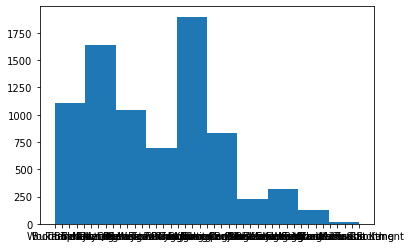

In [8]:
plt.hist(nbh)

In [9]:
hist = Counter(nbh_group)
hh = np.array(hist.values()).reshape(-1,1)

In [13]:
import fiona

<BarContainer object of 5 artists>

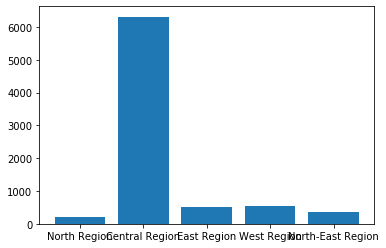

In [14]:
mm = list(hist.values())
plt.bar(list(hist.keys()),list(hist.values()))